In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

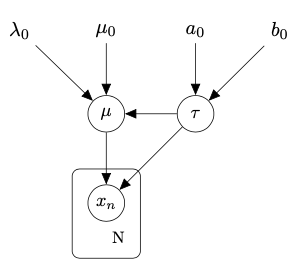

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [17]:
def generate_data(mu, tau, N):
  x = np.linspace(-10, 10, N)
  # Insert your code here
  sigma = 1 / np.sqrt(tau)   # precision τ = 1/σ²
  np.random.seed(10)
  D = np.random.normal(mu, sigma, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



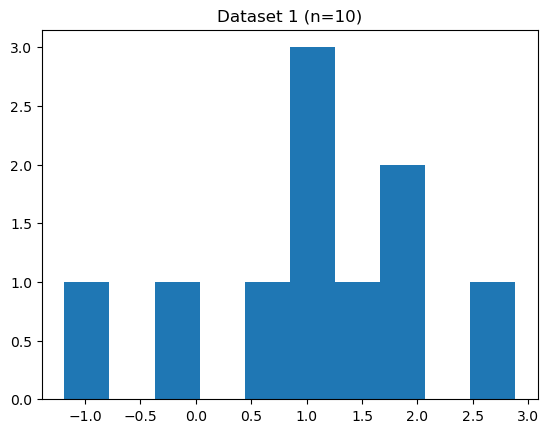

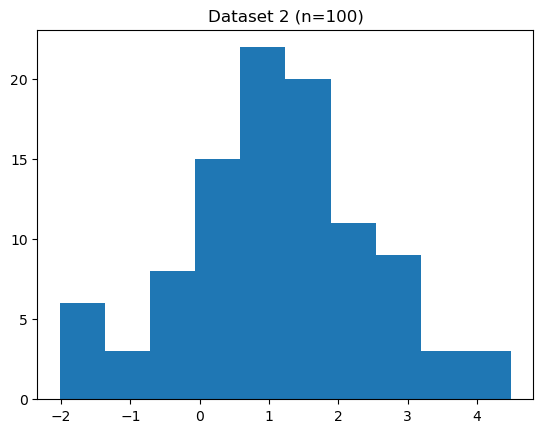

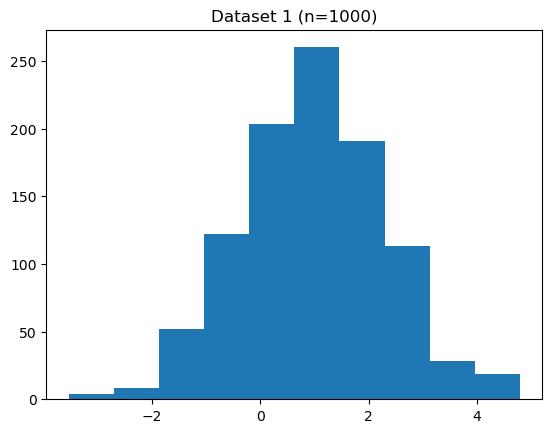

In [20]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
#
#
#
plt.figure()
plt.hist(dataset_1)
plt.title("Dataset 1 (n=10)")

plt.figure()
plt.hist(dataset_2)
plt.title("Dataset 2 (n=100)")

plt.figure()
plt.hist(dataset_3)
plt.title("Dataset 1 (n=1000)")

plt.show()


### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [ ]:
# from the theory we know that:
# mu_ml = 1/n * sum(x_i)
# tau_ml = n / sum((x_i - mu_ml)(x_i - mu_ml)^T)
def ML_est(data):
  mu_ml= np.mean(data)
  variance_ml= 1/len(data) *np.sum((data - mu_ml)**2)
  tau_ml= 1/variance_ml
  return mu_ml, tau_ml

## Test the ML estimator on the three datasets
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))

(1.0845817205152941, 0.884224414821371)
(1.1123121218037397, 0.5346648053646902)
(0.9794138084900784, 0.5683337478172712)


### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [ ]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation

  return exact_post_dist_parameters

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [ ]:
# prior parameters
mu_0 =
lambda_0 =
a_0 =
b_0 =

Continue with a helper function that computes ELBO:


In [ ]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here


  return elbo


Now, implement the CAVI algorithm:

In [ ]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau =

  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence

  return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


In [ ]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot


